In [13]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [14]:
%reload_ext dotenv
%dotenv

cannot find .env file


In [1]:
!pip uninstall pyarrow
!pip install pyarrow

Found existing installation: pyarrow 17.0.0
Uninstalling pyarrow-17.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/benchmarks/*
    /usr/local/lib/python3.10/dist-packages/cmake_modules/AWSSDKVariables.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/BuildUtils.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/DefineOptions.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindAWSSDKAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindAzure.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindBrotliAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindClangTools.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindGTestAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindInferTools.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindLLVMAlt.cmake
    /usr/local/lib/python3.10/dist-packages/cmake_modules/FindOpenSSLAlt.cmake
 

In [3]:
from tqdm.notebook import tqdm
import pandas as pd

from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [4]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [5]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [7]:
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

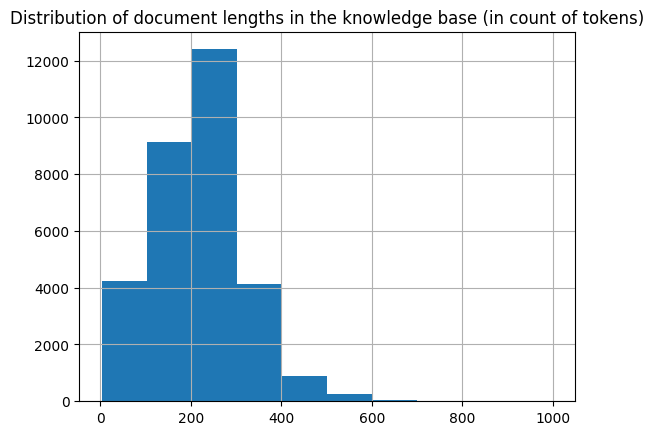

In [8]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/17995 [00:00<?, ?it/s]

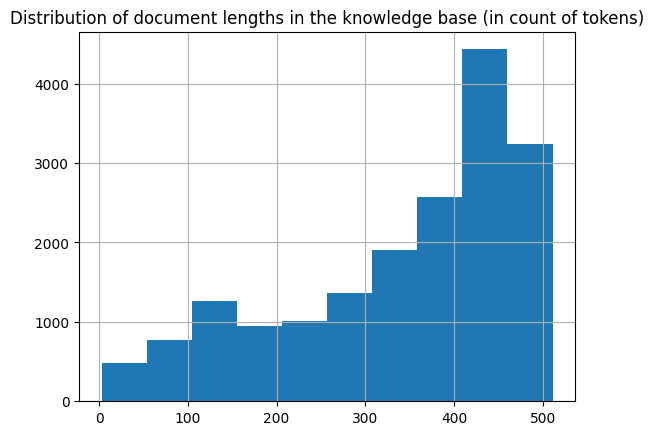

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [10]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
<ipython-input-10-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [11]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [12]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [13]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [14]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


In [15]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [16]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8.\n\nWhat is 5+3? Answer: 8.\n\nWhat is 10-2? Answer: 8.\n\nWhat is 16÷2? Answer: 8.\n\nWhat is 9*1? Answer: 9.\n\nWhat is 7+1? Answer: 8.\n\nWhat is 8-1? Answer: 7.\n\nWhat is 100-92? Answer: 8.\n\nWhat is 1000÷100? Answer: 10.\n\nWhat is 10000÷1000? Answer: 1.\n\nWhat is 100000÷10000? Answer: 1.\n\nWhat is 1000000÷100000? Answer: 1.\n\nWhat is 10000000÷1000000? Answer: 1.\n\nWhat is 100000000÷10000000? Answer: 1.\n\nWhat is 1000000000÷1000000000? Answer: 1.\n\nWhat is 10000000000÷10000000000? Answer: 1.\n\nWhat is 100000000000÷100000000000? Answer: 1.\n\nWhat is 1000000000000÷10000000000000? Answer: 1.\n\nWhat is 10000000000000÷100000000000000? Answer: 1.\n\nWhat is 100000000000000÷1000000000000000? Answer: 1.\n\nWhat is 1000000000000000÷10'}]

In [17]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [19]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)])

final_prompt = RAG_PROMPT_TEMPLATE.format(question="How to create a pipeline object?", context=context)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. These could be strings, dictionaries, or any other format that suits your use case.

2. Inherit the `Pipeline` class from the `transformers` module. This class provides the necessary methods for implementing the pipeline.

3. Implement the four required methods: `preprocess`, `_forward`, `postprocess`, and `_sanitize_parameters`. Here's a brief explanation of what each method does:

   - `preprocess`: Preprocesses the input data into a format that the model can understand. This could involve tokenizing text, converting images to a specific format, or any other necessary preprocessing step.

   - `_forward`: Runs the forward pass of the model using the preprocessed input data. This method should return the output of the model.

   - `postprocess`: Postprocesses the output of the model to produce the final result. This could involve denormalizing features, decoding text, or any other nece

In [20]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



In [21]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [22]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

=> Retrieving documents...


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


=> Generating answer...


In [23]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the necessary module, `pipeline`, from the Hugging Face Transformers library:

   ```python
   from transformers import pipeline
   ```

2. Specify the task you want to perform with the pipeline. For example, to create a pipeline for object detection, call `pipeline()` and pass the task name as an argument, such as `'object-detection'` or `'object_detection'`. If you're loading a pre-trained model, you can also provide the path to the model checkpoint:

   ```python
   >>> object_detector = pipeline('object-detection')
   >>> object_detector = pipeline('object_detection', pretrained='path/to/checkpoint')
   ```

3. Alternatively, you can create a pipeline for other tasks, such as sentiment analysis or text-to-image generation, following similar steps.

4. To use the pipeline, simply pass an input to its `()` method. The pipeline will return a list of di